In [193]:
import math
import matplotlib.pyplot as plt
import gprsim
import numpy as np

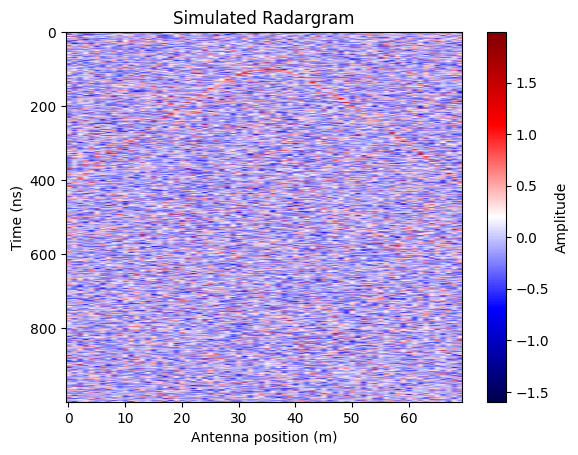

In [238]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
SNR = 0.02
wavetype = 'gaussian'

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)

plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel("Antenna position (m)")
plt.ylabel("Time (ns)")
plt.title("Simulated Radargram")
plt.colorbar(label="Amplitude")
plt.show()

(Text(0.5, 235.72222222222223, 'x distance (m)'),
 Text(50.222222222222214, 0.5, 't (ns)'))

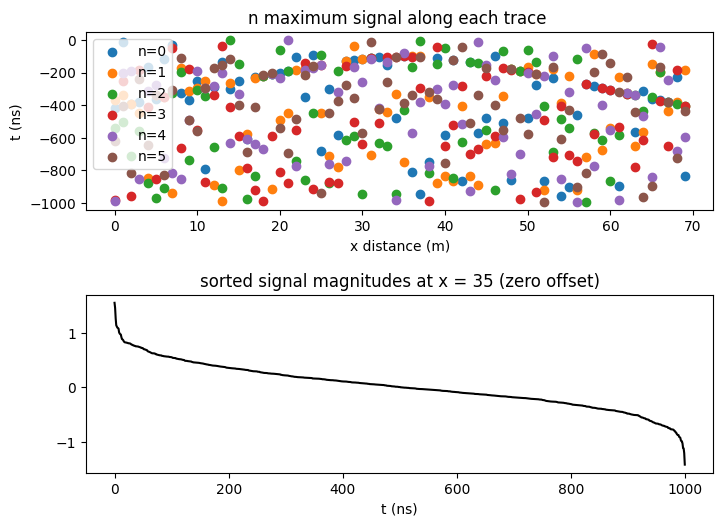

In [239]:
# Just take the max, if some are wrong due to noise our alg will work it out
fig, ax = plt.subplots(2, figsize = (7,5))
fig.tight_layout(h_pad=4)
for n in range(0,6):
    t = data.argsort(axis=0)[::-1,:][n]* -1 # Ttake the indices of the max 5 signals
    x = np.arange(0, data.shape[1]) * dx # 
    ax[0].scatter(x, t, label=f"n={n}")

sample_signal = data[:,35]
ax[1].plot(np.sort(sample_signal)[::-1], c='black')
ax[1].set_title("sorted signal magnitudes at x = 35 (zero offset)")
ax[1].set_xlabel("t (ns)")
ax[0].legend()
ax[0].set_title("n maximum signal along each trace ")
ax[0].set_xlabel("x distance (m)"), ax[0].set_ylabel("t (ns)")

# The idea is that if we take n maximums, even with super noisy data we will have sufficient data to get the hyperbola

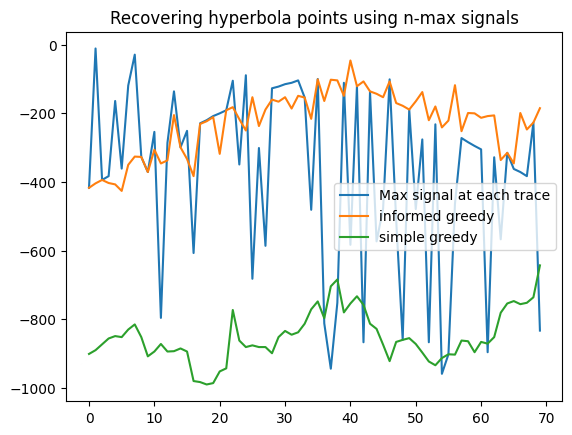

In [240]:
def pinv_fit(t, x):
    # Our linearized form of the hyperbola equation
    A = np.column_stack([t**2, 2.0*x, -1.0*np.ones_like(x)])
    b = x**2
    # solve with pseudoinverse -- do this twice to reduce outliers
    consts = np.linalg.pinv(A) @ b
    return A, consts, b

def minimize_tracewise_slope_greedy(data, n_candidates):
    t = data.argsort(axis=0)[::-1,:][0]
    t_og = data.argsort(axis=0)[::-1,:][0]* -1
    x = np.arange(0, data.shape[1]) * dx # 
    t_nmax = data.argsort(axis=0)[::-1,:] * -1

    candidates = np.array([data.argsort(axis=0)[::-1,:][n] for n in range(0,n_candidates)])
    for i in range(0,len(x)): # go through each trace
        candidate_indices = candidates[:, i]
        min_slope = math.inf
        slopes = []
        for cand in candidate_indices:
            slope = np.abs((cand-t[i-1])/(x[i]-x[i-1])) # calcuate the slope for each candidate index
            slopes.append(slope)
            if slope < min_slope: # If the slope suddenly becomes eggerdious
                t[i]=cand
                min_slope = slope
    # plt.plot(x, t_og, label='og')
    # plt.plot(x, -t, label='heh')
    # plt.legend()
    return x, t

def minimize_tracewise_slope_window(data, n_candidates, dx, window):
    n_traces = data.shape[1]
    x = np.arange(n_traces) * dx
    
    # Precompute top-n candidate indices for each column
    candidates = data.argsort(axis=0)[::-1, :][:n_candidates, :]
    
    # Initialize with the top max of the first column
    t = np.zeros(n_traces, dtype=int)
    t[0] = candidates[0, 0]
    
    for i in range(1, n_traces):
        # Look back over a small window (min ensures bounds)
        start = max(0, i - window)
        prev_t = np.mean(t[start:i])  # local average trend
        
        candidate_indices = candidates[:, i]
        # Compute slope relative to local mean
        slopes = np.abs((candidate_indices - prev_t) / dx)
        # Choose the one that gives the smallest slope
        t[i] = candidate_indices[np.argmin(slopes)]
    
    return x, t

# --- Example usage ---
# x, t = find_smooth_trace(data, dx)
t, x = data.argsort(axis=0)[::-1,:][0], np.arange(0, data.shape[1]) * dx 
x_window, t_window = minimize_tracewise_slope_window(data, 10, 1, 5)
x_greedy, t_greedy = minimize_tracewise_slope_greedy(data, 15)
plt.title("Recovering hyperbola points using n-max signals")
plt.plot(x, -t, label="Max signal at each trace")
plt.plot(x_window, -t_window, label="informed greedy")
plt.plot(x_greedy, -t_greedy, label="simple greedy")
plt.legend()

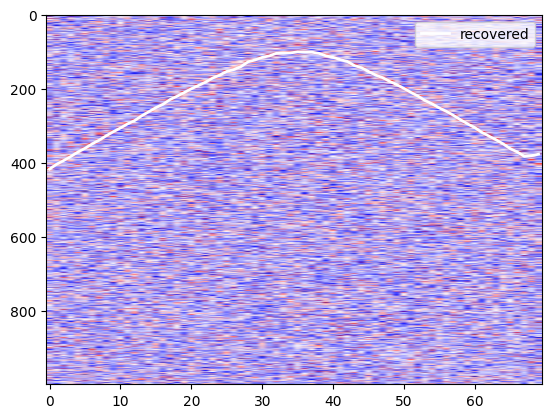

In [251]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_path_dp(data, lam):
    """
    Finds a smooth, high-intensity path through a 2D matrix using dynamic programming.

    Parameters:
        data : 2D numpy array (rows = t, columns = x)
        lam  : smoothness penalty strength

    Returns:
        path : list of t indices, one for each column
    """
    n_t, n_x = data.shape
    C = np.zeros_like(data)
    backtrack = np.zeros_like(data, dtype=int)

    # Initialize first column
    C[:, 0] = data[:, 0]

    # DP forward pass
    for x in range(1, n_x):
        for t in range(n_t):
            # Compute smoothness penalty relative to previous column
            penalties = C[:, x-1] - lam * (np.arange(n_t) - t)**2
            best_prev = np.argmax(penalties)
            C[t, x] = data[t, x] + penalties[best_prev]
            backtrack[t, x] = best_prev

    # Backtrack the best path
    path = np.zeros(n_x, dtype=int)
    path[-1] = np.argmax(C[:, -1])
    for x in range(n_x-2, -1, -1):
        path[x] = backtrack[path[x+1], x+1]

    return path


# Recover the path
t = smooth_path_dp(data, lam=0.003)

plt.imshow(data, aspect='auto', cmap='seismic')
plt.plot(np.arange(0, data.shape[1]) * dx, t, 'w-', lw=2, label='recovered')
plt.legend()
plt.show()


v = 432576640.6 m/s, depth z = 60.33 m, apex x0 = 9.000 m, t0 = 1.3e-08 s
v = 56780320.9 m/s, depth z = nan m, apex x0 = 34.358 m, t0 = nan s, risiduals=[-742.93668308 -742.53013283 -616.82773993 -610.47413178 -497.43413294
 -441.46779391 -386.82531602 -334.08825686 -282.48628712 -273.09308388
 -187.30959173 -142.65226224  -31.00805482  -57.2529069    45.51880156
   19.80290736   55.17663138   68.6191106   120.77413839  150.94867659
  178.71635898  205.03863156  296.11574216  251.60579205  272.25831743
  290.84088394  307.71344757  322.40857361  499.00992122  520.64364521
  355.40380795  362.56441455  367.91731036  371.36283328  372.97328719
  372.42819008  370.19653999  366.20603308  360.0607568   352.17538362
  342.21926989  330.65398788  349.45856072  301.24515167  283.91710451
  619.45565324  243.32471575  213.44320244  195.37915347  168.52362184
  139.74625656  109.04705762   76.08209311   41.88315876    5.60723057
  -32.96807472  -73.27644195 -115.29442122 -158.99621763 -205.2760

Text(0.5, 1.0, 'max signal along each trace (blue) with polyfit (black) and pinv (orange)')

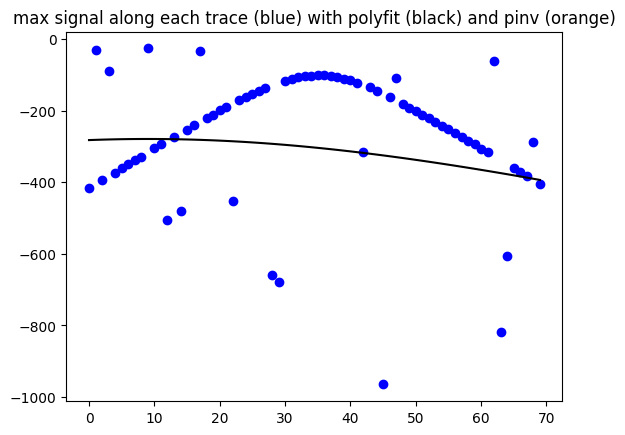

In [70]:
import math
import matplotlib.pyplot as plt
import gprsim
import numpy as np

t = data.argmax(axis=0)* -1 # There are some issues here, will fix later
x = np.arange(0, data.shape[1]) * dx #
plt.scatter(x, t, c="blue")

# polyfit
v, z, x0, t0 = gprsim.fit_hyperbola(data, 1, 'fit_from_max', dx, dt)
t_fit = (2/v)*np.sqrt(z**2 + (x-x0)**2) * 1/dt
plt.plot(x, -t_fit, c="black")

# Our method
v, z, x0, t0 = gprsim.fit_hyperbola(data, 1, 'robust_fit', dx, dt)
t_fit = (2/v)*np.sqrt(z**2 + (x-x0)**2) * 1/dt
plt.plot(x, -t_fit, c='orange')
plt.title("max signal along each trace (blue) with polyfit (black) and pinv (orange)")

Text(0.5, 1.0, 'c-10%')

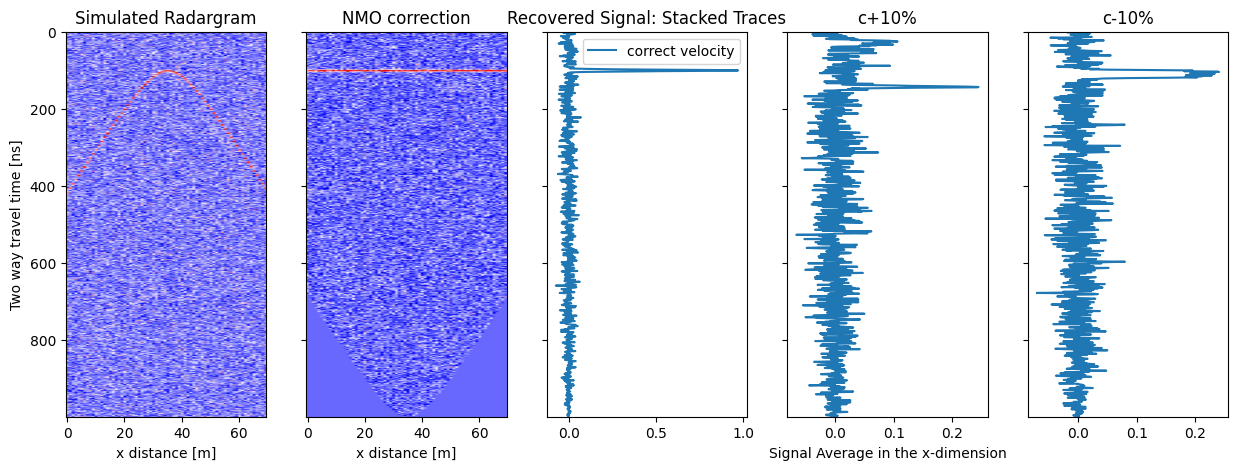

In [26]:
import numpy as np

stackh = lambda array : np.sum(array, axis=1)/array.shape[1]

t_0, x_0 = 100, 35 # The zero-offset time [ns] and 'CMP' [m] (the position of the reflector which we assume we know -- though can be estimated pretty easily)
eps_r = 3.0
wavetype = 'gaussian'
SNR = 0.06

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
corrected = gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt) 


fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
plt.gca()
axs[0].imshow(data, aspect='auto', cmap='seismic')
im = axs[1].imshow(corrected, aspect='auto', cmap='seismic')
stack = stackh(corrected)
axs[2].plot(stack, range(0,len(stack)), label='correct velocity')


eps_r = 3.3
stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
axs[3].plot(stack, range(0,len(stack)), label='velocity+10%')


eps_r = 2.7
stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
axs[4].plot(stack, range(0,len(stack)), label='velocity-10%')


'''Desktop/ResolutionGuyotProj/Code/Point_Counting/Matrix_indev/Kmask/RoPeR_prcs/GPR_modeling
Making the plot pretty
'''
axs[0].set_title('Simulated Radargram'); axs[0].set_ylabel('Two way travel time [ns]'); axs[0].set_xlabel('x distance [m]')
axs[1].set_title('NMO correction'); axs[1].set_xlabel('x distance [m]')
axs[2].set_title('Recovered Signal: Stacked Traces'); axs[2].legend()
axs[3].set_title('c+10%'); axs[3].set_xlabel('Signal Average in the x-dimension')
axs[4].set_title('c-10%')

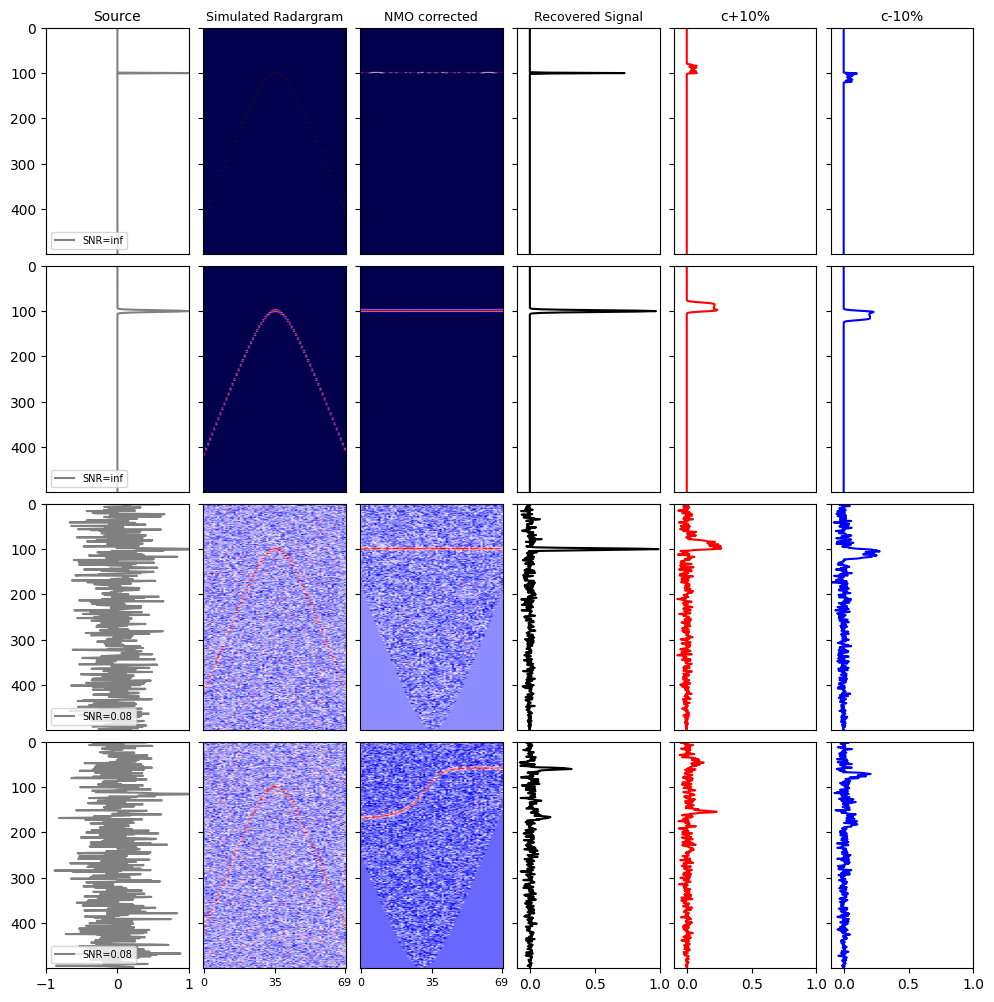

In [71]:
correct_t_0 = 100; correct_x_0 = 35; correct_eps_r = 3.0
params = {0:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'spike', 'SNR':math.inf}, 
          1:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':math.inf}, 
          2:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':0.08}, 
          3:{'t_0':correct_t_0+20, 'x_0':correct_x_0-5, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':0.08}}

rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 5e-7)  # grid (x,z)
reflectors = [(35, 50e-9)]

fig, axs = plt.subplots(4, 6, figsize=(10,10), sharey=True)
fig.tight_layout()
if isinstance(axs, np.ndarray):
    grid = axs.shape
    
for i in range(grid[0]):
    # Simulate a survey
    t_0, x_0 = params[i]['t_0'], params[i]['x_0']
    eps_r = params[i]['eps_r']
    wavetype = params[i]['wavetype']
    SNR = params[i]['SNR']

    data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
    corrected = gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt) 
    stack = stackh(corrected)

    axs[i][0].plot(data[:, x_0], range(0,len(stack)), c='gray', label=f'SNR={SNR}')
    axs[i][0].set_xlim(-1, 1)
    axs[i][0].legend(fontsize=7, loc='lower left')
    
    axs[i][1].imshow(data, aspect='auto', cmap='seismic')
    axs[i][1].set_xticks([0, 35, 69])
    for label in axs[i][1].get_xticklabels():
        label.set_fontsize(8)
    
    im = axs[i][2].imshow(corrected, aspect='auto', cmap='seismic')
    axs[i][2].set_xticks([0, 35, 69])
    for label in axs[i][2].get_xticklabels():
        label.set_fontsize(8)

    axs[i][3].plot(stack, range(0,len(stack)), label='correct velocity', c='black')
    axs[i][3].set_xlim(-0.1, 1)



    eps_r = 3.3
    stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
    axs[i][4].plot(stack, range(0,len(stack)), label='velocity+10%', c='red')
    axs[i][4].set_xlim(-0.1, 1)


    eps_r = 2.7
    stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
    axs[i][5].plot(stack, range(0,len(stack)), label='velocity-10%', c='blue')
    axs[i][5].set_xlim(-0.1, 1)

    if i != 3:
        for j in range(0, 6):
            axs[i][j].set_xticks([])
        

    
    # Making the plot pretty
    # '''
axs[0, 0].set_title('Source', fontsize=10, pad=5); axs[0, 1].set_title('Simulated Radargram', fontsize=9, pad=5); axs[0, 2].set_title('NMO corrected', fontsize=9, pad=5); axs[0, 3].set_title('Recovered Signal', fontsize=9, pad=5); axs[0, 4].set_title('c+10%', fontsize=10, pad=5);  axs[0, 5].set_title('c-10%', fontsize=10, pad=5);
plt.subplots_adjust(hspace=0.05, wspace=0.1)

plt.savefig('/Users/coltenrodriguez/desktop/Senior_Thesis/Thesis/Figures/NMO_Figure_Draft.png')
    # axs[1].set_title('NMO correction'); axs[1].set_xlabel('x distance [m]'), ; fig.colorbar(im, ax=axs[1], orientation='vertical')
    # axs[2].set_title('Recovered Signal: Stacked Traces'); axs[2].legend()
    # axs[3].set_title('c+10%'); axs[3].set_xlabel('Signal Average in the x-dimension')
    # axs[4].set_title('c-10%')

In [16]:
import numpy as np
f = 10^-4
p = 2200
L = 600000

(-f + np.sqrt(f**2 - 4*((1/L)*(3.67e-3))))/(2/L)

np.float64(5999999.999632999)

In [23]:
(-f + np.sqrt((f**2) * (1/L)*(3.67e-3)*4))/(2/L)

np.float64(3000469.254728266)